<a href="https://colab.research.google.com/github/dmzapata1/Ciencia_de_Datos/blob/main/Proyecto_Housing_in_London.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error


pd.set_option('display.max_columns', None)


 Modelo para predecir la media de precios en las viviendas de los diferentes municipos de Londres, Reino Unido. KPI = Errores de estimación menores a 25%.

# <span style="color:green">1. Descargar los datos.

In [4]:
from pandas.io.parsers.readers import read_csv
## Definimos una función para extraer datos.
#DOWNLOAD_ROOT es la base del GitHub donde vamos a estar descargando las bases de datos.
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/a2Proyectos/MachineLearning_Data/main/"
#Complementos con la dirección especifica de la base de datos que queremos.
LONDON_SALARY = "Capitulo_2/housing_in_london_yearly_variables.csv"
LONDON_HOUSING = "Capitulo_2/housing_in_london_monthly_variables.csv"
LONDON_MAP = os.path.abspath("") + "\map\London_Borough_Excluding_MHW.shp"

def extraer_datos(root, database):
          csv_path = root + database
          return pd.read_csv(csv_path)


In [5]:
df1 = extraer_datos(DOWNLOAD_ROOT, LONDON_HOUSING)
df2 = extraer_datos(DOWNLOAD_ROOT, LONDON_SALARY)

In [6]:
df1.head(5)

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


In [7]:
df2.head(2)

,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.0,NaN,48922,0,6581.0,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.0,NaN,23620,3,162444.0,NaN,NaN,NaN,1


In [8]:
#Filtrar los datos
df2 = df2[['median_salary', 'area', 'date']]
df2

,median_salary,area,date
0,33020.0,city of london,1999-12-01
1,21480.0,barking and dagenham,1999-12-01
2,19568.0,barnet,1999-12-01
3,18621.0,bexley,1999-12-01
4,18532.0,brent,1999-12-01
...,...,...,...
1066,30446.0,great britain,2019-12-01
1067,30500.0,england and wales,2019-12-01
1068,27434.0,northern ireland,2019-12-01
1069,30000.0,scotland,2019-12-01


In [9]:
df = pd.merge(df2,df1)
df.head(5)

,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag
0,33020.0,city of london,1999-12-01,169309,E09000001,97.0,NaN,1
1,21480.0,barking and dagenham,1999-12-01,68812,E09000002,267.0,NaN,1
2,19568.0,barnet,1999-12-01,149510,E09000003,619.0,NaN,1
3,18621.0,bexley,1999-12-01,93905,E09000004,460.0,NaN,1
4,18532.0,brent,1999-12-01,123398,E09000005,395.0,NaN,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 0 to 902
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_salary  881 non-null    float64
 1   area           903 non-null    object 
 2   date           903 non-null    object 
 3   average_price  903 non-null    int64  
 4   code           903 non-null    object 
 5   houses_sold    860 non-null    float64
 6   no_of_crimes   617 non-null    float64
 7   borough_flag   903 non-null    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 63.5+ KB


In [11]:
 df['area'].value_counts()

city of london            21
westminster               21
newham                    21
redbridge                 21
richmond upon thames      21
southwark                 21
sutton                    21
tower hamlets             21
waltham forest            21
wandsworth                21
north east                21
lewisham                  21
north west                21
east midlands             21
west midlands             21
london                    21
south east                21
south west                21
inner london              21
outer london              21
merton                    21
lambeth                   21
barking and dagenham      21
greenwich                 21
barnet                    21
bexley                    21
brent                     21
bromley                   21
camden                    21
croydon                   21
ealing                    21
enfield                   21
hackney                   21
kingston upon thames      21
hammersmith an

# <span style="color:green">2. Análisis Exploratorio </span>

In [12]:
df.describe()

,median_salary,average_price,houses_sold,no_of_crimes,borough_flag
count,881.000000,9.030000e+02,860.000000,617.000000,903.000000
mean,28789.284904,3.099169e+05,3853.289535,2038.090762,0.767442
std,6508.321987,1.875274e+05,12917.661579,879.517578,0.422697
min,15684.000000,4.829800e+04,6.000000,0.000000,0.000000
25%,24582.000000,1.892870e+05,246.000000,1542.000000,1.000000
50%,28284.000000,2.608930e+05,351.000000,2008.000000,1.000000
75%,31589.000000,3.875970e+05,626.000000,2402.000000,1.000000
max,61636.000000,1.364185e+06,119458.000000,7461.000000,1.000000


In [13]:
# Quitar ceros de la notación científica.
pd.options.display.float_format = "{:,.2f}".format

In [14]:
df.describe(percentiles = [0.01, 0.05, .25, .75, .95, .99])

,median_salary,average_price,houses_sold,no_of_crimes,borough_flag
count,881.00,903.00,860.00,617.00,903.00
mean,"28,789.28","309,916.87","3,853.29","2,038.09",0.77
std,"6,508.32","187,527.43","12,917.66",879.52,0.42
min,"15,684.00","48,298.00",6.00,0.00,0.00
1%,"16,995.40","68,825.58",23.18,0.00,0.00
5%,"19,302.00","115,422.60",137.85,926.00,0.00
25%,"24,582.00","189,287.00",246.00,"1,542.00",1.00
50%,"28,284.00","260,893.00",351.00,"2,008.00",1.00
75%,"31,589.00","387,597.00",626.00,"2,402.00",1.00
95%,"39,653.00","645,099.00","13,224.75","3,008.40",1.00


<function matplotlib.pyplot.show(close=None, block=None)>

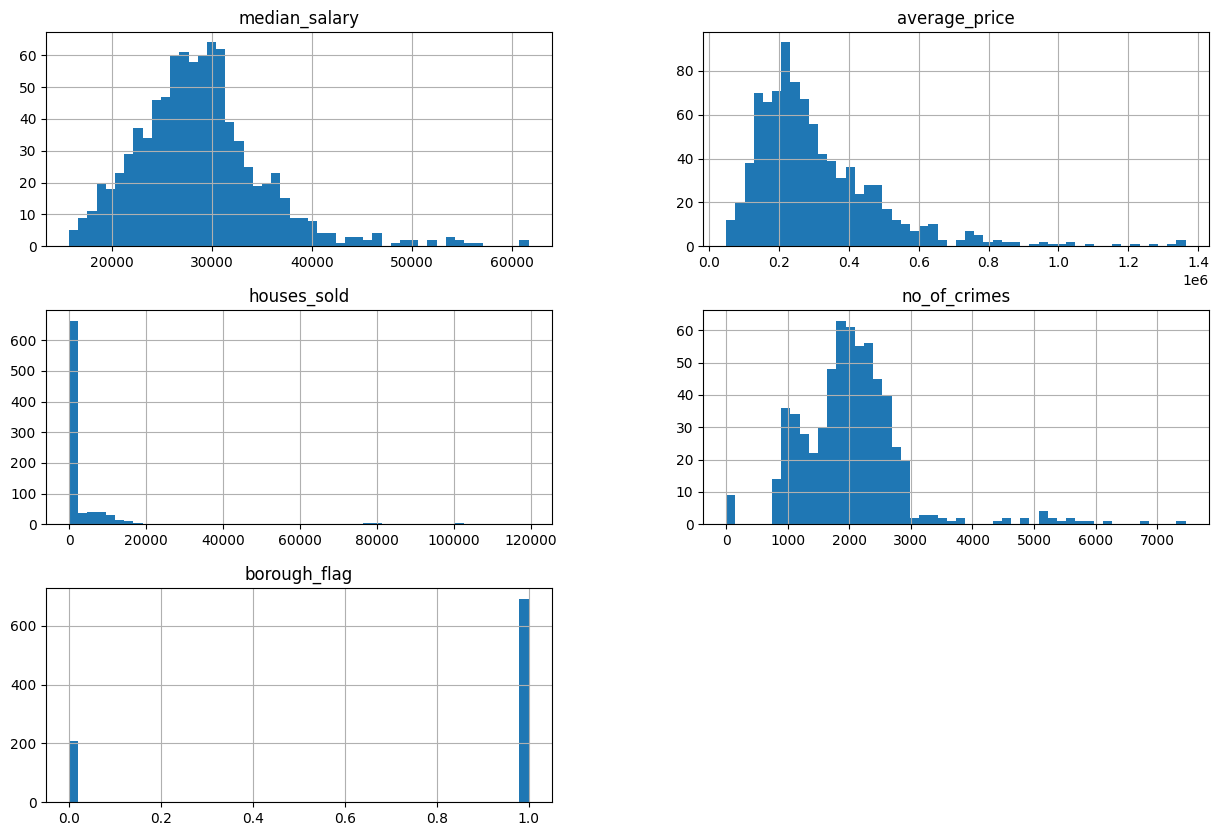

In [15]:
%matplotlib inline
df.hist(bins = 50, figsize=(15,10))
plt.show

In [16]:
df.head(5)

,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag
0,"33,020.00",city of london,1999-12-01,169309,E09000001,97.00,NaN,1
1,"21,480.00",barking and dagenham,1999-12-01,68812,E09000002,267.00,NaN,1
2,"19,568.00",barnet,1999-12-01,149510,E09000003,619.00,NaN,1
3,"18,621.00",bexley,1999-12-01,93905,E09000004,460.00,NaN,1
4,"18,532.00",brent,1999-12-01,123398,E09000005,395.00,NaN,1


In [17]:
df[['median_salary', 'average_price', 'houses_sold']].corr()

,median_salary,average_price,houses_sold
median_salary,1.00,0.64,-0.17
average_price,0.64,1.00,-0.19
houses_sold,-0.17,-0.19,1.00


<Axes: >

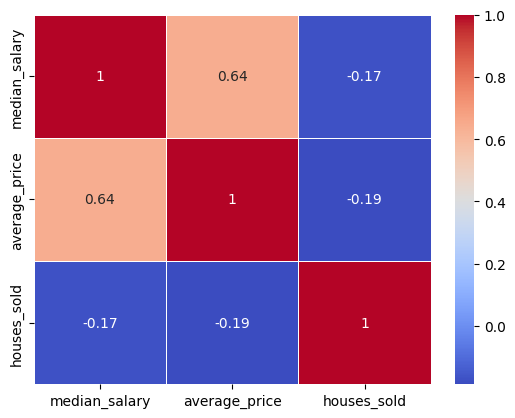

In [18]:
sns.heatmap(df[['median_salary', 'average_price', 'houses_sold']].corr(), annot = True, linewidths = 0.5, cmap = 'coolwarm')

<Axes: xlabel='median_salary', ylabel='average_price'>

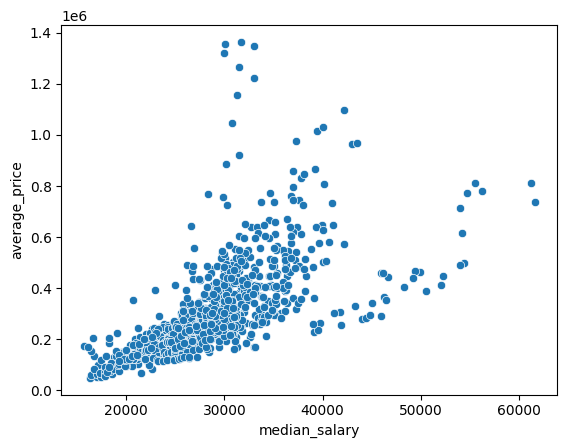

In [19]:
sns.scatterplot(x=df['median_salary'], y=df['average_price'])

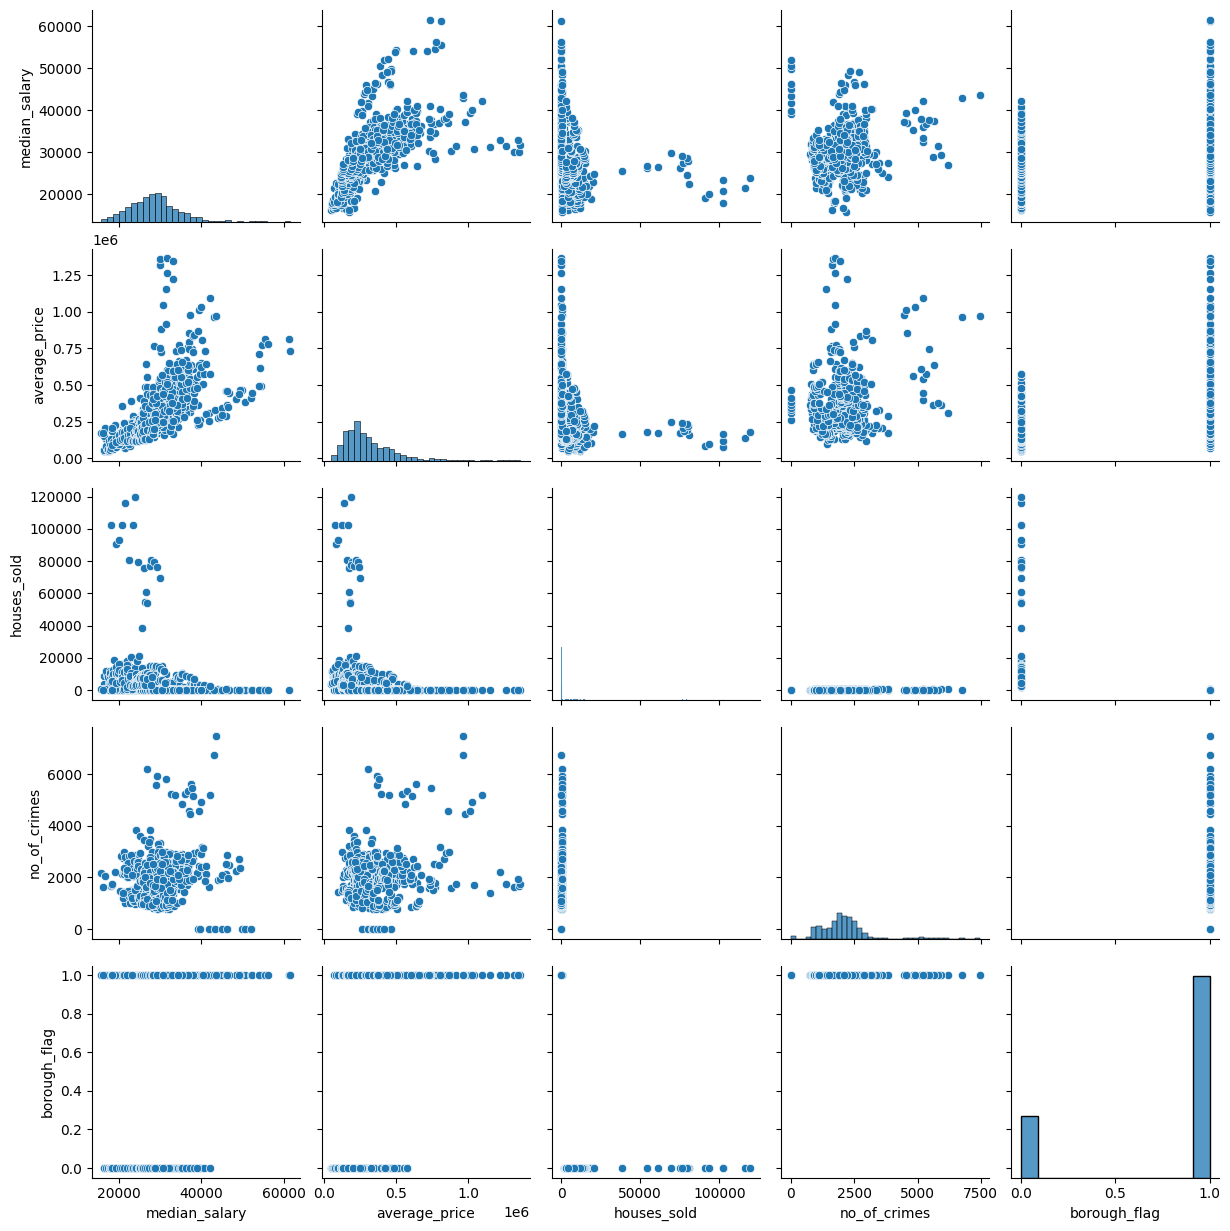

In [20]:
sns.pairplot(df)

# <span style="color:green">3. Crear un set de entrenamiento y de prueba </span>

In [21]:
from numpy.random.mtrand import random_sample

In [22]:
set_entrenamiento, set_prueba = train_test_split(df, test_size = 0.3, random_state=45)

In [23]:
print(len(set_entrenamiento))
print(len(set_prueba))

632
271


## 3.1 Evitar Sesgo


In [24]:
df['salary_cat'] = pd.cut(df['median_salary'], bins= [0, 10_000, 20_000,30_000, 40_000, np.inf], labels = [1,2,3,4,5])

In [25]:
df

,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
0,"33,020.00",city of london,1999-12-01,169309,E09000001,97.00,NaN,1,4
1,"21,480.00",barking and dagenham,1999-12-01,68812,E09000002,267.00,NaN,1,3
2,"19,568.00",barnet,1999-12-01,149510,E09000003,619.00,NaN,1,2
3,"18,621.00",bexley,1999-12-01,93905,E09000004,460.00,NaN,1,2
4,"18,532.00",brent,1999-12-01,123398,E09000005,395.00,NaN,1,2
...,...,...,...,...,...,...,...,...,...
898,"32,120.00",south east,2019-12-01,324515,E12000008,NaN,NaN,0,4
899,"28,654.00",south west,2019-12-01,259011,E12000009,NaN,NaN,0,3
900,NaN,inner london,2019-12-01,575511,E13000001,NaN,NaN,0,NaN
901,NaN,outer london,2019-12-01,424774,E13000002,NaN,NaN,0,NaN


<Axes: >

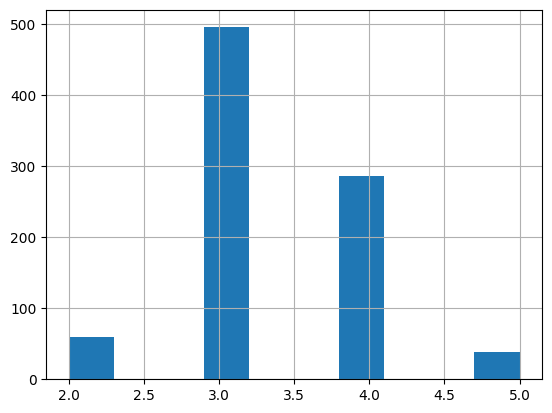

In [26]:
df['salary_cat'].hist()

In [27]:
df['salary_cat'].value_counts().sort_values(ascending=False)

3    496
4    287
2     59
5     39
1      0
Name: salary_cat, dtype: int64

In [28]:
df = df.dropna(subset=['median_salary'])
df = df.reset_index()

df['salary_cat'] = pd.cut(df['median_salary'],
                          bins=[10000, 20000, 30000, 40000, np.inf],
                          labels=[1,2,3,4])

<Axes: >

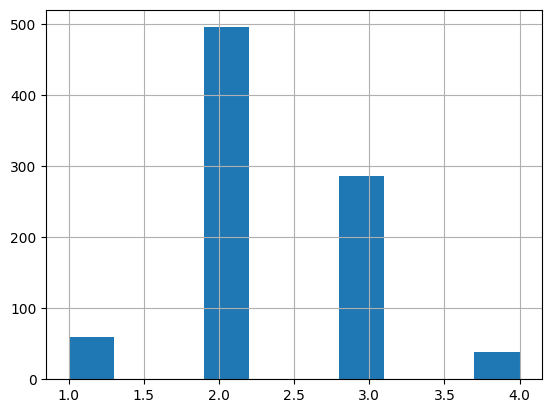

In [29]:
df['salary_cat'].hist()

In [30]:
df['salary_cat'].value_counts()

2    496
3    287
1     59
4     39
Name: salary_cat, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [32]:
dividir = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state=45)

In [33]:
for ent_index, prueba_index in dividir.split(df, df['salary_cat']):
  cat_set_ent = df.loc[ent_index]
  cat_set_prueba = df.loc[prueba_index]

In [34]:
cat_set_prueba['salary_cat'].value_counts()

2    149
3     86
1     18
4     12
Name: salary_cat, dtype: int64

In [35]:
cat_set_ent['salary_cat'].value_counts()

2    347
3    201
1     41
4     27
Name: salary_cat, dtype: int64

In [36]:
ent_index

array([323, 424, 560, 481,  53, 742, 440, 536, 193, 392, 157, 362, 187,
       447, 146, 290, 625, 567, 192, 768, 172, 369, 412, 266, 813, 162,
        91, 596, 642, 546, 494,  32,  46,   4, 414, 566, 727, 303, 349,
       132, 667, 806, 760,  31, 672, 611, 857, 622, 674, 352, 501, 302,
       495, 776, 316, 490, 607,  74, 510, 150, 516, 280, 532, 722,  10,
       736, 248, 121, 715, 496, 614, 197, 307, 739, 389,  75,  43, 277,
       256, 348, 870, 493, 373, 817, 224,  45,  62, 664, 867, 765, 415,
       550, 663,  13, 291, 244,  71,  59, 695, 680, 865, 492, 587, 214,
       497, 784, 160, 359, 322, 846, 500, 491, 569, 427, 286, 698, 450,
       597, 426, 182, 758, 714, 874, 379, 761, 687, 109, 641, 386, 860,
       619, 824, 862, 219, 754, 356, 616, 418, 128, 367, 164, 814, 827,
       399,  26, 301, 802, 836, 449, 626, 774, 250, 688, 470, 176, 483,
       615, 220, 705, 572, 228, 365, 366, 518, 282, 161,  15, 206, 196,
       432, 757,  69, 839, 102, 318, 347, 741, 829, 171, 309, 63

In [37]:
cat_set_prueba

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
158,164,"19,125.00",east midlands,2002-12-01,98179,E12000004,"9,098.00",NaN,0,1
767,783,"29,134.00",enfield,2017-12-01,395284,E09000010,225.00,"2,053.00",1,2
93,97,"24,095.00",hackney,2001-12-01,162859,E09000012,252.00,"2,862.00",1,2
578,592,"23,781.00",north east,2012-12-01,114860,E12000001,"2,354.00",NaN,0,2
130,136,"22,675.00",croydon,2002-12-01,174796,E09000008,661.00,"2,795.00",1,2
...,...,...,...,...,...,...,...,...,...,...
778,794,"31,308.00",kingston upon thames,2017-12-01,485525,E09000021,154.00,914.00,1,3
56,58,"17,418.00",havering,2000-12-01,116342,E09000016,321.00,NaN,1,1
606,620,"37,325.00",islington,2013-12-01,539846,E09000019,294.00,"1,871.00",1,3
819,836,"32,976.00",kensington and chelsea,2018-12-01,1345805,E09000020,84.00,"1,922.00",1,3


In [38]:
cat_set_ent

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2
424,438,"28,234.00",ealing,2009-12-01,279575,E09000009,312.00,"2,392.00",1,2
560,574,"28,326.00",havering,2012-12-01,223743,E09000016,231.00,"1,452.00",1,2
481,495,"30,806.00",lewisham,2010-12-01,223141,E09000023,242.00,"2,119.00",1,3
53,55,"25,264.00",hammersmith and fulham,2000-12-01,262106,E09000013,255.00,NaN,1,2
...,...,...,...,...,...,...,...,...,...,...
618,633,"31,491.00",wandsworth,2013-12-01,484071,E09000032,659.00,"1,632.00",1,3
249,262,"24,209.00",brent,2005-12-01,247157,E09000005,303.00,"2,577.00",1,2
436,450,"27,497.00",kingston upon thames,2009-12-01,283400,E09000021,221.00,914.00,1,2
326,339,"24,798.00",south east,2006-12-01,219389,E12000008,"20,999.00",NaN,0,2


In [39]:
df = cat_set_ent.copy()

In [40]:
df.head()

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2
424,438,"28,234.00",ealing,2009-12-01,279575,E09000009,312.00,"2,392.00",1,2
560,574,"28,326.00",havering,2012-12-01,223743,E09000016,231.00,"1,452.00",1,2
481,495,"30,806.00",lewisham,2010-12-01,223141,E09000023,242.00,"2,119.00",1,3
53,55,"25,264.00",hammersmith and fulham,2000-12-01,262106,E09000013,255.00,NaN,1,2


# Geopandas

In [41]:
import geopandas as gpd

In [42]:
# Leer el mapa

In [43]:
londres_map = gpd.read_file('/content/drive/MyDrive/A2_MACHINE_LEARNING/CAPITULO_2_REGRESION/map/London_Borough_Excluding_MHW.shp')

In [44]:
londres_map.head(5)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,"8,649.44",0.00,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,"15,013.49",0.00,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,"5,658.54",60.76,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,"5,554.43",0.00,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


<Axes: >

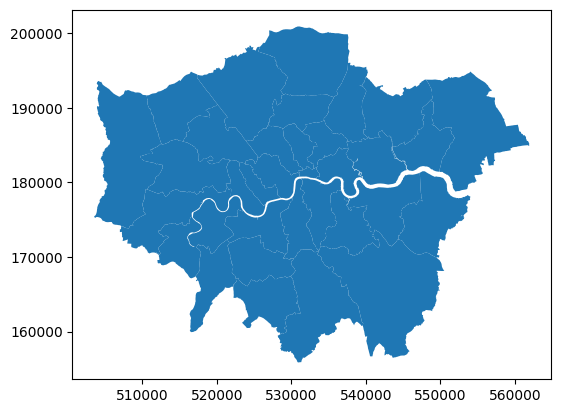

In [45]:
londres_map.plot()

In [46]:
df.head(1)

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2


In [47]:
londres_map.head(1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [48]:
# Juntar los dataframes
londres_map.columns.str.lower()

Index(['name', 'gss_code', 'hectares', 'nonld_area', 'ons_inner', 'sub_2009',
       'sub_2006', 'geometry'],
      dtype='object')

In [49]:
londres_map.columns = londres_map.columns.str.lower()

In [50]:
londres_map.head(1)

,name,gss_code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [51]:
df.head(1)

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2


In [52]:
londres_map.head(1)

,name,gss_code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [53]:
londres_map.rename({'name':'area', 'gss_code':'code'}, axis=1, inplace = True)

In [54]:
londres_map.head(1)

,area,code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [55]:
londres_map = londres_map.filter(items = ['area', 'code','hectares','geometry'])

In [56]:
londres_map.head(1)

,area,code,hectares,geometry
0,Kingston upon Thames,E09000021,"3,726.12","POLYGON ((516401.600 160201.800, 516407.300 16..."


In [57]:
df.head(1)

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2


In [58]:
df_m = df.groupby('area').agg({'average_price':['mean'], 'houses_sold':'sum', 'median_salary':['mean']})

In [59]:
df_m

,average_price,houses_sold,median_salary
,mean,sum,mean
area,,,
barking and dagenham,"182,996.43","2,937.00","28,425.43"
barnet,"327,315.14","6,485.00","26,764.43"
bexley,"215,843.00","3,976.00","26,580.08"
brent,"287,339.23","3,734.00","25,206.77"
bromley,"278,804.75","5,836.00","25,316.25"
camden,"551,825.56","3,628.00","33,496.56"
city of london,"492,358.44",510.00,"49,425.72"
croydon,"264,942.57","6,099.00","28,527.71"


In [60]:
df_m.columns[2][0]

'median_salary'

In [61]:
primeros_elementos = [columna[0] for columna in df_m.columns]
primeros_elementos

['average_price', 'houses_sold', 'median_salary']

In [62]:
df_m.columns = [columna[0] for columna in df_m.columns]

In [63]:
df_m.head(5)

,average_price,houses_sold,median_salary
area,,,
barking and dagenham,"182,996.43","2,937.00","28,425.43"
barnet,"327,315.14","6,485.00","26,764.43"
bexley,"215,843.00","3,976.00","26,580.08"
brent,"287,339.23","3,734.00","25,206.77"
bromley,"278,804.75","5,836.00","25,316.25"


In [64]:
df_m.reset_index(inplace=True)

In [65]:
df_m.head(1)

,area,average_price,houses_sold,median_salary
0,barking and dagenham,"182,996.43","2,937.00","28,425.43"


In [66]:
londres_map.head(1)

,area,code,hectares,geometry
0,Kingston upon Thames,E09000021,"3,726.12","POLYGON ((516401.600 160201.800, 516407.300 16..."


In [67]:
londres_map['area'] = londres_map['area'].str.lower()

In [68]:
# Unimos los dataframes
londres_map = pd.merge(londres_map, df_m, on ="area")

In [69]:
londres_map.head(2)

,area,code,hectares,geometry,average_price,houses_sold,median_salary
0,kingston upon thames,E09000021,"3,726.12","POLYGON ((516401.600 160201.800, 516407.300 16...","318,729.36","2,376.00","27,117.45"
1,croydon,E09000008,"8,649.44","POLYGON ((535009.200 159504.700, 535005.500 15...","264,942.57","6,099.00","28,527.71"


(500648.735, 564876.965, 153596.645, 203188.055)

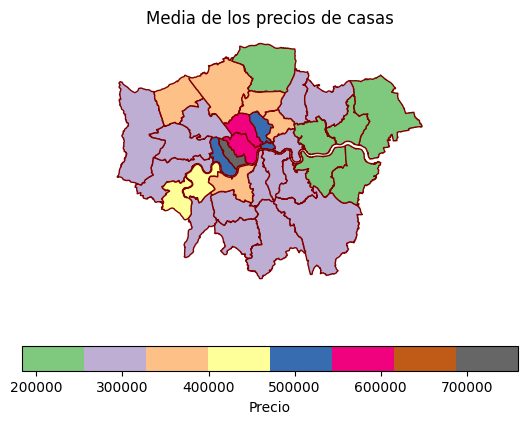

In [70]:
plt = londres_map.plot(column = 'average_price', cmap = 'Accent', edgecolor = 'maroon', legend = 'True', legend_kwds = {'label':'Precio', 'orientation':'horizontal'})
plt.set_title('Media de los precios de casas')
plt.axis('off')

(500648.735, 564876.965, 153596.645, 203188.055)

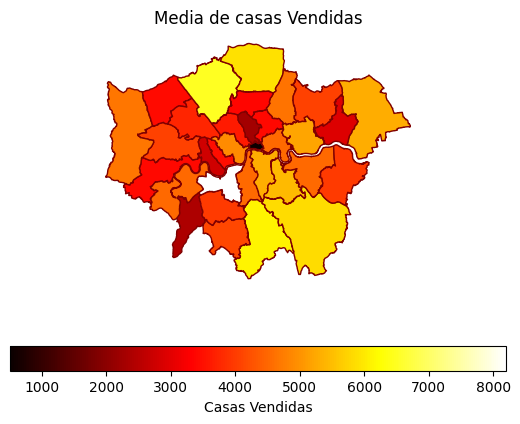

In [71]:
plt = londres_map.plot(column = 'houses_sold', cmap = 'hot', edgecolor = 'maroon', legend = 'True', legend_kwds = {'label':'Casas Vendidas', 'orientation':'horizontal'})
plt.set_title('Media de casas Vendidas')
plt.axis('off')

Text(0.5, 1.0, 'Salario Promedio')

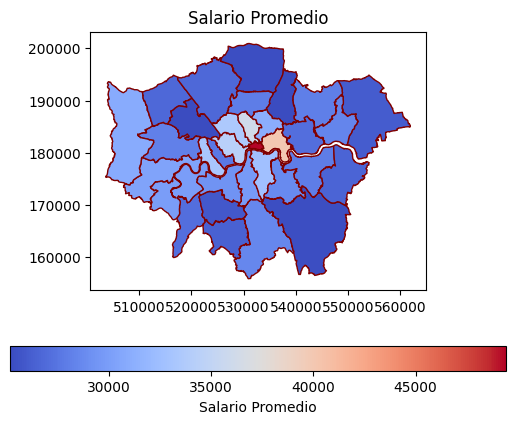

In [72]:
plt = londres_map.plot(column = 'median_salary', cmap = 'coolwarm', edgecolor = 'maroon', legend = 'True', legend_kwds = {'label':'Salario Promedio', 'orientation':'horizontal'})
plt.set_title('Salario Promedio')

<ipython-input-73-eebbb68ec391>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap = 'plasma')


<Axes: >

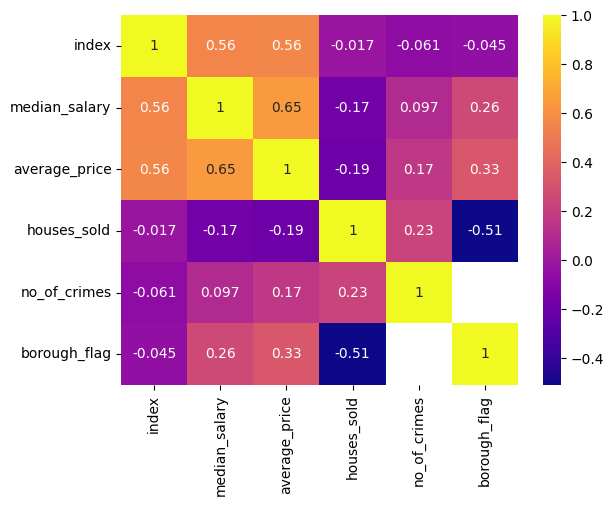

In [73]:
sns.heatmap(df.corr(), annot=True, cmap = 'plasma')

In [74]:
df.head(1)

,index,median_salary,area,date,average_price,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,151841,E12000004,"10,413.00",NaN,0,2


In [75]:
matriz = df.corr(method = 'pearson')
matriz

<ipython-input-75-707850d17a6a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz = df.corr(method = 'pearson')


,index,median_salary,average_price,houses_sold,no_of_crimes,borough_flag
index,1.00,0.56,0.56,-0.02,-0.06,-0.05
median_salary,0.56,1.00,0.65,-0.17,0.10,0.26
average_price,0.56,0.65,1.00,-0.19,0.17,0.33
houses_sold,-0.02,-0.17,-0.19,1.00,0.23,-0.51
no_of_crimes,-0.06,0.10,0.17,0.23,1.00,NaN
borough_flag,-0.05,0.26,0.33,-0.51,NaN,1.00


In [76]:
matriz['average_price'].sort_values(ascending = False)

average_price    1.00
median_salary    0.65
index            0.56
borough_flag     0.33
no_of_crimes     0.17
houses_sold     -0.19
Name: average_price, dtype: float64

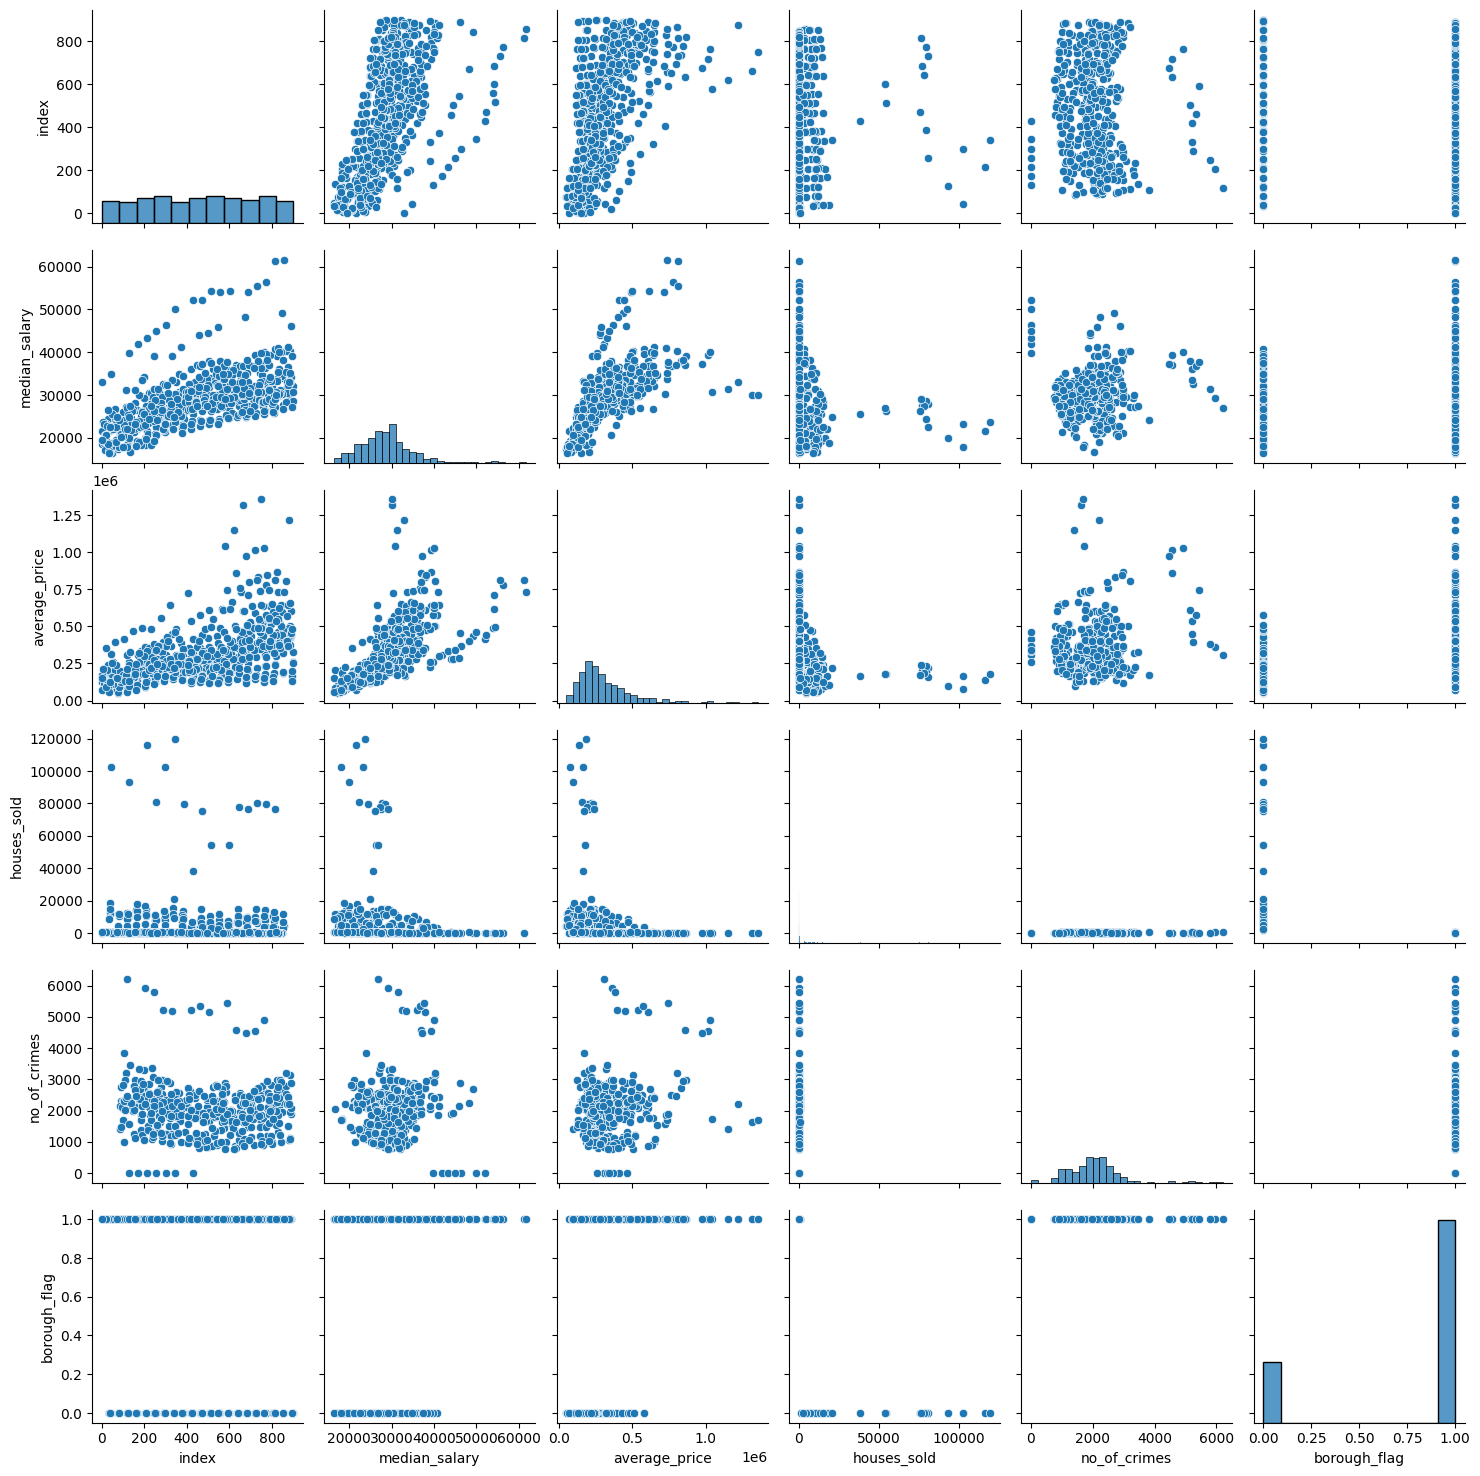

In [77]:
sns.pairplot(df)


<Axes: xlabel='average_price', ylabel='median_salary'>

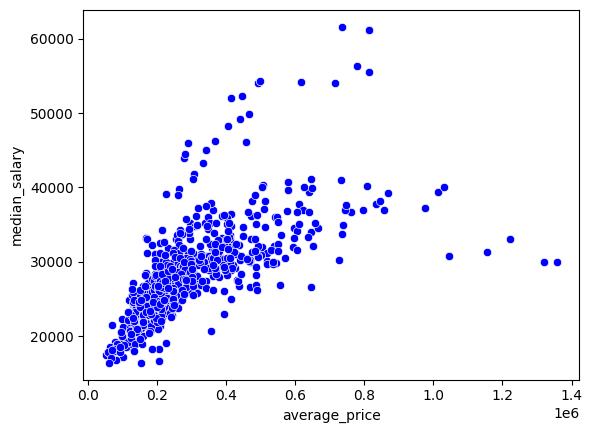

In [78]:
sns.scatterplot(x=df['average_price'], y = df['median_salary'], color = 'blue' )

In [79]:
df['vendidas_poblacion'] = df['no_of_crimes']/df['houses_sold']

In [80]:
matriz = df.corr()

<ipython-input-80-7d0907f67722>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz = df.corr()


In [81]:
matriz['average_price'].sort_values(ascending = False)

average_price         1.00
median_salary         0.65
index                 0.56
vendidas_poblacion    0.33
borough_flag          0.33
no_of_crimes          0.17
houses_sold          -0.19
Name: average_price, dtype: float64

# Limpieza de Datos

Recordar que todo se va a realizar sobre el conjunto de datos de entrenamiento. El conjunto de datos de prueba no se considera para esta etapa.

In [82]:
df_label = cat_set_ent['average_price']
df_label

323    151841
424    279575
560    223743
481    223141
53     262106
        ...  
618    484071
249    247157
436    283400
326    219389
841    734872
Name: average_price, Length: 616, dtype: int64

In [83]:
df = cat_set_ent.drop('average_price', axis=1)
df

,index,median_salary,area,date,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,E12000004,"10,413.00",NaN,0,2
424,438,"28,234.00",ealing,2009-12-01,E09000009,312.00,"2,392.00",1,2
560,574,"28,326.00",havering,2012-12-01,E09000016,231.00,"1,452.00",1,2
481,495,"30,806.00",lewisham,2010-12-01,E09000023,242.00,"2,119.00",1,3
53,55,"25,264.00",hammersmith and fulham,2000-12-01,E09000013,255.00,NaN,1,2
...,...,...,...,...,...,...,...,...,...
618,633,"31,491.00",wandsworth,2013-12-01,E09000032,659.00,"1,632.00",1,3
249,262,"24,209.00",brent,2005-12-01,E09000005,303.00,"2,577.00",1,2
436,450,"27,497.00",kingston upon thames,2009-12-01,E09000021,221.00,914.00,1,2
326,339,"24,798.00",south east,2006-12-01,E12000008,"20,999.00",NaN,0,2


In [84]:
df.isna().sum()/len(df)

index           0.00
median_salary   0.00
area            0.00
date            0.00
code            0.00
houses_sold     0.04
no_of_crimes    0.31
borough_flag    0.00
salary_cat      0.00
dtype: float64

In [85]:
# no_of_crimes supera el 30% de nulos.
df.drop('no_of_crimes', axis=1, inplace=True)

In [86]:
df.isna().sum()

index             0
median_salary     0
area              0
date              0
code              0
houses_sold      27
borough_flag      0
salary_cat        0
dtype: int64

In [87]:
median = df['houses_sold'].median()

In [88]:
df['houses_sold'].fillna(median, inplace=True)

In [89]:
df.isna().sum()

index            0
median_salary    0
area             0
date             0
code             0
houses_sold      0
borough_flag     0
salary_cat       0
dtype: int64

In [90]:
# Rellenar con SimpleImputer
df = cat_set_ent.drop('average_price', axis=1)


In [91]:
df.isna().sum()

index              0
median_salary      0
area               0
date               0
code               0
houses_sold       27
no_of_crimes     193
borough_flag       0
salary_cat         0
dtype: int64

In [92]:
df_num = df.drop(['area','code','date'], axis=1)
df_num.head(1)

,index,median_salary,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00","10,413.00",NaN,0,2


In [93]:
df_num.drop('no_of_crimes', axis=1, inplace=True)

In [94]:
df_num.head(1)

,index,median_salary,houses_sold,borough_flag,salary_cat
323,336,"21,946.00","10,413.00",0,2


In [95]:
from sklearn.impute import SimpleImputer

In [96]:
impute = SimpleImputer(strategy = 'mean')

In [97]:
impute.fit(df_num)

SimpleImputer()

In [98]:
X = impute.transform(df_num)

In [99]:
X

array([[3.36000000e+02, 2.19460000e+04, 1.04130000e+04, 0.00000000e+00,
        2.00000000e+00],
       [4.38000000e+02, 2.82340000e+04, 3.12000000e+02, 1.00000000e+00,
        2.00000000e+00],
       [5.74000000e+02, 2.83260000e+04, 2.31000000e+02, 1.00000000e+00,
        2.00000000e+00],
       ...,
       [4.50000000e+02, 2.74970000e+04, 2.21000000e+02, 1.00000000e+00,
        2.00000000e+00],
       [3.39000000e+02, 2.47980000e+04, 2.09990000e+04, 0.00000000e+00,
        2.00000000e+00],
       [8.60000000e+02, 6.16360000e+04, 4.17265025e+03, 1.00000000e+00,
        4.00000000e+00]])

In [100]:
df_transform = pd.DataFrame(X, columns = df_num.columns, index = df_num.index)
df_transform

,index,median_salary,houses_sold,borough_flag,salary_cat
323,336.00,"21,946.00","10,413.00",0.00,2.00
424,438.00,"28,234.00",312.00,1.00,2.00
560,574.00,"28,326.00",231.00,1.00,2.00
481,495.00,"30,806.00",242.00,1.00,3.00
53,55.00,"25,264.00",255.00,1.00,2.00
...,...,...,...,...,...
618,633.00,"31,491.00",659.00,1.00,3.00
249,262.00,"24,209.00",303.00,1.00,2.00
436,450.00,"27,497.00",221.00,1.00,2.00
326,339.00,"24,798.00","20,999.00",0.00,2.00


In [101]:
df.head(1)

,index,median_salary,area,date,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,E12000004,"10,413.00",NaN,0,2


In [102]:
df_transform['index'] = df_transform['index'].astype(int)

In [103]:
df_transform.isna().sum()

index            0
median_salary    0
houses_sold      0
borough_flag     0
salary_cat       0
dtype: int64

In [104]:
df_cat = df[['area','code','date', 'index']]

In [105]:
pd.merge(df_cat, df_transform, how='inner', on='index')

,area,code,date,index,median_salary,houses_sold,borough_flag,salary_cat
0,east midlands,E12000004,2006-12-01,336,"21,946.00","10,413.00",0.00,2.00
1,ealing,E09000009,2009-12-01,438,"28,234.00",312.00,1.00,2.00
2,havering,E09000016,2012-12-01,574,"28,326.00",231.00,1.00,2.00
3,lewisham,E09000023,2010-12-01,495,"30,806.00",242.00,1.00,3.00
4,hammersmith and fulham,E09000013,2000-12-01,55,"25,264.00",255.00,1.00,2.00
...,...,...,...,...,...,...,...,...
611,wandsworth,E09000032,2013-12-01,633,"31,491.00",659.00,1.00,3.00
612,brent,E09000005,2005-12-01,262,"24,209.00",303.00,1.00,2.00
613,kingston upon thames,E09000021,2009-12-01,450,"27,497.00",221.00,1.00,2.00
614,south east,E12000008,2006-12-01,339,"24,798.00","20,999.00",0.00,2.00


In [106]:
df.head(1)

,index,median_salary,area,date,code,houses_sold,no_of_crimes,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,E12000004,"10,413.00",NaN,0,2


In [107]:
# fin de la prueba

# Manejo de variables categóricas

In [108]:
df.isna().sum()

index              0
median_salary      0
area               0
date               0
code               0
houses_sold       27
no_of_crimes     193
borough_flag       0
salary_cat         0
dtype: int64

In [109]:
df.drop('no_of_crimes', axis=1, inplace=True)

In [110]:
median = df['houses_sold'].median()

In [111]:
df['houses_sold'].fillna(median,inplace=True)

In [112]:
df.isna().sum()

index            0
median_salary    0
area             0
date             0
code             0
houses_sold      0
borough_flag     0
salary_cat       0
dtype: int64

# Tratamiento de Variables Categóricas

In [113]:
df.head()

,index,median_salary,area,date,code,houses_sold,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,E12000004,"10,413.00",0,2
424,438,"28,234.00",ealing,2009-12-01,E09000009,312.00,1,2
560,574,"28,326.00",havering,2012-12-01,E09000016,231.00,1,2
481,495,"30,806.00",lewisham,2010-12-01,E09000023,242.00,1,3
53,55,"25,264.00",hammersmith and fulham,2000-12-01,E09000013,255.00,1,2


In [114]:
df.isna().sum()

index            0
median_salary    0
area             0
date             0
code             0
houses_sold      0
borough_flag     0
salary_cat       0
dtype: int64

In [115]:
df_cat = df[['area']]

In [116]:
df_cat

,area
323,east midlands
424,ealing
560,havering
481,lewisham
53,hammersmith and fulham
...,...
618,wandsworth
249,brent
436,kingston upon thames
326,south east


In [117]:
# OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder


In [118]:
ordinal_encoder = OrdinalEncoder()

In [119]:
df_oe = ordinal_encoder.fit_transform(df_cat)

In [120]:
df_oe

array([[ 9.],
       [ 8.],
       [17.],
       [25.],
       [14.],
       [36.],
       [28.],
       [30.],
       [38.],
       [22.],
       [30.],
       [40.],
       [27.],
       [40.],
       [27.],
       [ 1.],
       [34.],
       [25.],
       [37.],
       [12.],
       [ 8.],
       [34.],
       [35.],
       [24.],
       [15.],
       [35.],
       [10.],
       [ 8.],
       [14.],
       [ 0.],
       [ 9.],
       [42.],
       [ 4.],
       [ 3.],
       [31.],
       [24.],
       [14.],
       [17.],
       [21.],
       [10.],
       [26.],
       [ 5.],
       [ 1.],
       [40.],
       [11.],
       [27.],
       [19.],
       [ 9.],
       [ 0.],
       [24.],
       [11.],
       [16.],
       [41.],
       [21.],
       [37.],
       [40.],
       [22.],
       [29.],
       [ 8.],
       [36.],
       [16.],
       [ 9.],
       [39.],
       [ 7.],
       [12.],
       [24.],
       [ 2.],
       [35.],
       [11.],
       [26.],
       [33.],
      

In [121]:
ordinal_encoder.categories_

[array(['barking and dagenham', 'barnet', 'bexley', 'brent', 'bromley',
        'camden', 'city of london', 'croydon', 'ealing', 'east midlands',
        'enfield', 'england', 'greenwich', 'hackney',
        'hammersmith and fulham', 'haringey', 'harrow', 'havering',
        'hillingdon', 'hounslow', 'inner london', 'islington',
        'kensington and chelsea', 'kingston upon thames', 'lambeth',
        'lewisham', 'london', 'merton', 'newham', 'north east',
        'north west', 'outer london', 'redbridge', 'richmond upon thames',
        'south east', 'south west', 'southwark', 'sutton', 'tower hamlets',
        'waltham forest', 'wandsworth', 'west midlands', 'westminster'],
       dtype=object)]

In [122]:
# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [123]:
encoder = OneHotEncoder()

In [124]:
df_1hot = encoder.fit_transform(df_cat)

# Normalización y Escalamiento

## MinMax Escaler

In [125]:
prueba = pd.DataFrame({'col1':[100,200,300,999], 'col2':[0,0,1,2], 'col3':[-10,0,1,2]})

In [126]:
prueba

,col1,col2,col3
0,100,0,-10
1,200,0,0
2,300,1,1
3,999,2,2


In [127]:
from sklearn.preprocessing import MinMaxScaler

In [128]:
scaler = MinMaxScaler()

In [129]:
pd.DataFrame(scaler.fit_transform(prueba),columns = prueba.columns)

,col1,col2,col3
0,0.00,0.00,0.00
1,0.11,0.00,0.83
2,0.22,0.50,0.92
3,1.00,1.00,1.00


## Estandarización

In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
escaler = StandardScaler()

In [132]:
pd.DataFrame(escaler.fit_transform(prueba),columns=prueba.columns)

,col1,col2,col3
0,-0.85,-0.90,-1.71
1,-0.57,-0.90,0.36
2,-0.28,0.30,0.57
3,1.70,1.51,0.78


# PipeLine

In [133]:
from sklearn.pipeline import Pipeline

In [134]:
pipeline = Pipeline([
    ('rellenar', SimpleImputer(strategy='median')),
    ('escalar', StandardScaler())
])

In [135]:
pd.DataFrame(pipeline.fit_transform(prueba), columns = prueba.columns)

,col1,col2,col3
0,-0.85,-0.90,-1.71
1,-0.57,-0.90,0.36
2,-0.28,0.30,0.57
3,1.70,1.51,0.78


# ColumnTransform: Aplicar pipeline a diferentes columnas

In [136]:
from sklearn.compose import ColumnTransformer

In [137]:
num = list(df_num)
cat = list(df_cat)

In [138]:
pipeline_completo = ColumnTransformer([
('num', pipeline, num),
('cat', OneHotEncoder(),cat)
])

In [139]:
df_preparado = pipeline_completo.fit_transform(df)

In [140]:
df_preparado.toarray()

array([[-0.46933763, -1.05081372,  0.47008784, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07015764, -0.09504471, -0.27092311, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46208235, -0.08106081, -0.27686528, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.02319528, -0.20706789, -0.27759888, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45759704, -0.61731289,  1.24667847, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.58135173,  4.98202216, -0.26820878, ...,  0.        ,
         0.        ,  0.        ]])

# Regresión Lineal

In [141]:
from sklearn.linear_model import LinearRegression

In [142]:
reg_lin = LinearRegression()

In [143]:
reg_lin.fit(df_preparado, df_label)

LinearRegression()

In [144]:
algunos_datos = df.iloc[:5]
algunos_datos

,index,median_salary,area,date,code,houses_sold,borough_flag,salary_cat
323,336,"21,946.00",east midlands,2006-12-01,E12000004,"10,413.00",0,2
424,438,"28,234.00",ealing,2009-12-01,E09000009,312.00,1,2
560,574,"28,326.00",havering,2012-12-01,E09000016,231.00,1,2
481,495,"30,806.00",lewisham,2010-12-01,E09000023,242.00,1,3
53,55,"25,264.00",hammersmith and fulham,2000-12-01,E09000013,255.00,1,2


In [145]:
datos_predecir = df_label.iloc[:5]
datos_predecir

323    151841
424    279575
560    223743
481    223141
53     262106
Name: average_price, dtype: int64

In [146]:
# Transformamos los datos.
datos_transformados = pipeline_completo.transform(algunos_datos)
datos_transformados

<5x48 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [147]:
pd.DataFrame(datos_transformados.toarray())


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,-0.47,-1.05,0.47,-1.83,-0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.07,-0.10,-0.27,0.55,-0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.46,-0.08,-0.28,0.55,-0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.15,0.30,-0.28,0.55,0.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-1.57,-0.55,-0.28,0.55,-0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [148]:
# Implementamos el modelo

In [149]:
vp = list(reg_lin.predict(datos_transformados))

In [150]:
vr = list(datos_predecir)

In [151]:
vp

[97433.98416017447,
 307933.2275211918,
 288247.45305803505,
 263537.8491199974,
 353306.1275310249]

In [152]:
vr

[151841, 279575, 223743, 223141, 262106]

In [153]:
vp = pd.Series(vp)
vr = pd.Series(vr)

In [154]:
# Porcentaje de Error de la Muestra.
abs((vr-vp)/vr).mean()*100

25.540695433299987

# RMSE

In [155]:
from sklearn.metrics import mean_squared_error

In [156]:
prediccion = reg_lin.predict(df_preparado)

In [157]:
error1 = mean_squared_error(df_label, prediccion)

In [158]:
error1

4725413596.980203

In [159]:
error1 = np.sqrt(error1)
error1

68741.64383385229

In [160]:
error2 = mean_squared_error(df_label,prediccion,squared=False)

In [161]:
error2

68741.64383385229

In [162]:
error1/df_label.mean()

0.22332662026480984

In [163]:
# Porcentaje de error del 22%

# Árbol de Decisión

In [164]:
from sklearn.tree import DecisionTreeRegressor

In [165]:
reg_arbol = DecisionTreeRegressor()

In [166]:
reg_arbol.fit(df_preparado, df_label)

DecisionTreeRegressor()

In [167]:
prediccion = reg_arbol.predict(df_preparado)

In [168]:
error = mean_squared_error(df_label, prediccion, squared=False)
error

0.0

# CrossValidation

In [169]:
from sklearn.model_selection import cross_val_score

In [170]:
resultados = cross_val_score(reg_arbol, df_preparado, df_label,scoring = 'neg_mean_squared_error', cv=10)

In [171]:
resultados

array([-8.23484927e+09, -5.07256270e+09, -5.64455199e+09, -4.31145645e+09,
       -8.25590980e+09, -9.50455773e+09, -3.88009408e+09, -3.23902503e+09,
       -4.44145833e+09, -5.37292413e+09])

In [172]:
rmse = np.sqrt(-resultados)
rmse

array([90746.07028149, 71221.92570308, 75130.23350006, 65661.6817784 ,
       90862.03717104, 97491.32131954, 62290.40115933, 56912.43298203,
       66644.26708019, 73300.23283986])

In [173]:
rmse.mean()/df_label.mean()

0.24374332009402544

# Random Forest (Bosque Aleatorio)

In [174]:
from sklearn.ensemble import RandomForestRegressor

In [175]:
reg_forest = RandomForestRegressor()

In [176]:
reg_forest.fit(df_preparado,df_label)

RandomForestRegressor()

In [177]:
prediccion = reg_forest.predict(df_preparado)

In [178]:
error = mean_squared_error(df_label, prediccion, squared=False)
error

21215.758597562184

In [179]:
error/df_label.mean()

0.06892537623044682

In [180]:
# Usamos CrossValidation
from sklearn.model_selection import cross_val_score

In [181]:
resultados = cross_val_score(reg_forest, df_preparado, df_label, scoring="neg_mean_squared_error", cv=10)

In [182]:
resultados

array([-4.73303919e+09, -2.63152601e+09, -3.08485922e+09, -2.38324434e+09,
       -4.33442798e+09, -3.74638366e+09, -3.55669361e+09, -2.68879595e+09,
       -2.80498999e+09, -2.78501825e+09])

In [183]:
rmse = np.sqrt(-resultados)

In [184]:
rmse

array([68797.08710144, 51298.40163478, 55541.50901093, 48818.48359679,
       65836.37273853, 61207.70911646, 59638.02153936, 51853.60112745,
       52962.15622425, 52773.27210031])

In [185]:
rmse.mean()

56872.66141903036

In [186]:
rmse.mean()/df_label.mean()

0.18476688295199178

# Grid Search

In [1]:
# Ajustar los hiperparámetros del modelo

In [187]:
from sklearn.model_selection import GridSearchCV

In [192]:
param_grid = [{
    'n_estimators': [3,10,30],
    'max_features': [2,4,6,8]
}]

In [193]:
grid_search = GridSearchCV(
    reg_forest, param_grid, cv=5,
    scoring = 'neg_mean_squared_error',
    return_train_score =True
)

In [194]:
grid_search.fit(df_preparado,df_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [195]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [196]:
grid_search.best_score_

-3080625888.082129

In [197]:
rmse = np.sqrt(-grid_search.best_score_)

In [198]:
rmse

55503.3862758132

In [199]:
rmse/df_label.mean()

0.1803184064115354

# Evaluación del Modelo en el Set de Prueba

In [200]:
# Modelo seleccionado: Random Forest

In [201]:
modelo_final = grid_search.best_estimator_
modelo_final

RandomForestRegressor(max_features=4, n_estimators=30)

In [202]:
Y = cat_set_prueba['average_price']
X = cat_set_prueba.drop(['average_price','no_of_crimes'], axis=1)

In [203]:
Y.head(1)

158    98179
Name: average_price, dtype: int64

In [204]:
X.head(1)

,index,median_salary,area,date,code,houses_sold,borough_flag,salary_cat
158,164,"19,125.00",east midlands,2002-12-01,E12000004,"9,098.00",0,1


In [205]:
# Pasamos los datos X por el pipeline

In [206]:
X_preparada = pipeline_completo.transform(X)

In [208]:
X_preparada.toarray()

array([[-1.14246467, -1.47960258,  0.37361923, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28000997,  0.04175429, -0.27730544, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40467113, -0.72416811, -0.27532472, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.6421047 ,  1.28677719, -0.27224359, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48742703,  0.62573402, -0.28764923, ...,  0.        ,
         0.        ,  0.        ],
       [-1.721667  , -0.738304  , -0.25617772, ...,  0.        ,
         0.        ,  0.        ]])

- Recordar que el modelo final ya no se entrena en el conjunto de prueba, es decir ya no se debe usar modelo_final.fit

In [209]:
prediccion_final = modelo_final.predict(X_preparada)

In [210]:
prediccion_final

array([  93838.66666667,  395860.23333333,  205070.73333333,
        127796.43333333,  179828.13333333,  313796.9       ,
        233681.8       ,  174098.96666667,  554460.76666667,
        302790.63333333,   78296.7       ,  497465.93333333,
        270326.33333333,  643695.83333333,  324595.        ,
        199492.13333333,  156019.56666667,  215047.93333333,
        561670.7       ,  138852.6       ,  464345.73333333,
        245533.        ,  128205.43333333,   69298.33333333,
        206700.6       ,  170008.4       ,  138728.03333333,
        272467.1       ,  146702.26666667,  348268.86666667,
        481912.5       ,  251602.8       ,  223807.43333333,
        374417.3       ,  769793.93333333,  288738.2       ,
        125801.5       ,  192970.16666667,  228205.3       ,
        246853.46666667,  125584.23333333,  157771.26666667,
        390061.23333333,  650076.3       ,  182484.53333333,
        242426.46666667,  165068.03333333,  253809.63333333,
        355134.6       ,

In [211]:
rmse_final = mean_squared_error(Y,prediccion_final, squared=False)

In [213]:
rmse_final/Y.mean()*100

16.659191937252196

In [214]:
# KPI: Disminuir el error por debajo del 25%. Objetivo logrado.

In [215]:
Y

158      98179
767     395284
93      162859
578     114860
130     174796
        ...   
778     485525
56      116342
606     539846
819    1345805
16      120228
Name: average_price, Length: 265, dtype: int64

In [219]:
prediccion = pd.DataFrame(prediccion_final)

In [220]:
prediccion

,0
0,"93,838.67"
1,"395,860.23"
2,"205,070.73"
3,"127,796.43"
4,"179,828.13"
...,...
260,"472,083.17"
261,"170,384.73"
262,"520,945.57"
263,"1,051,905.83"


In [221]:
prediccion.rename({0:'prediccion'}, axis=1, inplace=True)

In [222]:
prediccion

,prediccion
0,"93,838.67"
1,"395,860.23"
2,"205,070.73"
3,"127,796.43"
4,"179,828.13"
...,...
260,"472,083.17"
261,"170,384.73"
262,"520,945.57"
263,"1,051,905.83"


In [236]:
valores_reales = pd.DataFrame(Y)

In [237]:
valores_reales.reset_index(drop=True, inplace=True)

In [238]:
valores_reales

,average_price
0,98179
1,395284
2,162859
3,114860
4,174796
...,...
260,485525
261,116342
262,539846
263,1345805


In [240]:
comparacion = pd.merge(valores_reales, prediccion, left_index=True, right_index=True)

In [241]:
comparacion

,average_price,prediccion
0,98179,"93,838.67"
1,395284,"395,860.23"
2,162859,"205,070.73"
3,114860,"127,796.43"
4,174796,"179,828.13"
...,...,...
260,485525,"472,083.17"
261,116342,"170,384.73"
262,539846,"520,945.57"
263,1345805,"1,051,905.83"


from matplotlib import pyplot as plt
comparacion['average_price'].plot(kind='hist', bins=20, title='average_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparacion['prediccion'].plot(kind='hist', bins=20, title='prediccion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparacion.plot(kind='scatter', x='average_price', y='prediccion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparacion['average_price'].plot(kind='line', figsize=(8, 4), title='average_price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparacion['prediccion'].plot(kind='line', figsize=(8, 4), title='prediccion')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: ylabel='Count'>

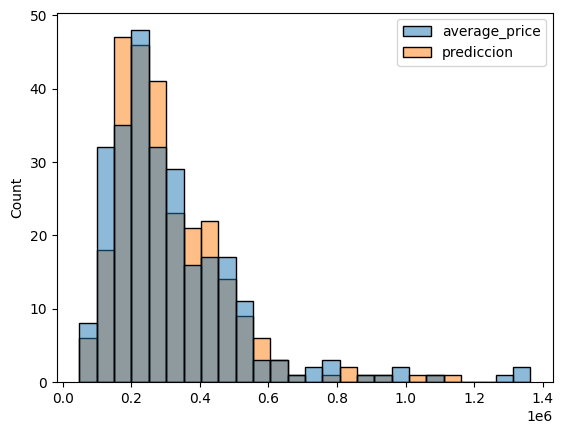

In [242]:
sns.histplot(comparacion)

In [243]:
comparacion['error'] = comparacion['average_price'] - comparacion['prediccion']


<Axes: xlabel='error', ylabel='Count'>

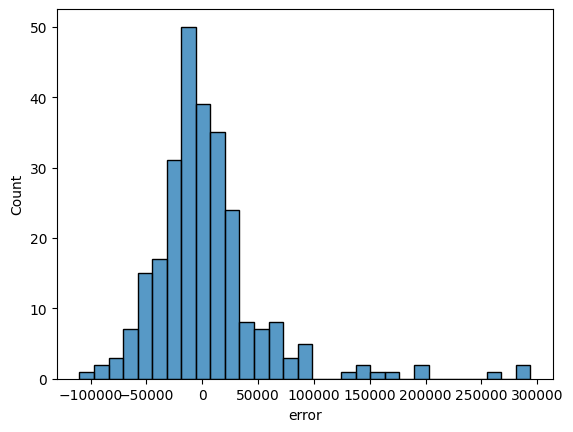

In [244]:
sns.histplot(comparacion['error'])